In [1]:
pip install scikit-learn==1.1.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 28.5 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.22.0 requires scikit-learn>=1.2.2, but you have scikit-learn 1.1.3 which is incompatible.


In [2]:
from multiprocessing import Pool
#from functools import partial
import numpy as np
#from numba import jit
import matplotlib.pyplot as plt

In [3]:
#TODO: loss of least square regression and binary logistic regression
'''
    pred() takes GBDT/RF outputs, i.e., the "score", as its inputs, and returns predictions.
    g() is the gradient/1st order derivative, which takes true values "true" and scores as input, and returns gradient.
    h() is the heassian/2nd order derivative, which takes true values "true" and scores as input, and returns hessian.
'''
class leastsquare(object):
    '''Loss class for mse. As for mse, pred function is pred=score.'''
    def pred(self,score):
        return score

    def g(self,true,score):
        return (score - true) # we can also use 2*(score - true) if we use mse = (true-score)^2, but it fundamentally doesn't effect the optimization

    def h(self,true,score):
        return np.ones_like(score) # we can also use 2*np.ones_like(score) if we use mse = (true-score)^2, but it doesn't effect the optimization. I have tried
                                   # using that too and the results were the same.

class logistic(object):
    '''Loss class for log loss. As for log loss, pred function is logistic transformation.'''
    def pred(self,score):
        return 1 / (1 + np.exp(-score))

    def g(self,true,score):
        predictions = self.pred(score)
        return predictions - true

    def h(self,true,score):
        predictions = self.pred(score)
        return predictions * (1 - predictions)

In [28]:
##### Random Forest with Multiprocessing #####
class RF(object):
    '''
    Class of Random Forest

    Parameters:
        n_threads: The number of threads used for fitting and predicting.
        loss: Loss function for gradient boosting.
            'mse' for regression task and 'log' for classfication task.
            A child class of the loss class could be passed to implement customized loss.
        max_depth: The maximum depth d_max of a tree.
        min_sample_split: The minimum number of samples required to further split a node.
        lamda: The regularization coefficient for leaf score, also known as lambda.
        gamma: The regularization coefficient for number of tree nodes, also know as gamma.
        rf: rf*m is the size of random subset of features, from which we select the best decision rule.
        num_trees: Number of trees.
    '''
    def __init__(self,
        n_threads = None, loss = 'mse',
        max_depth = 3, min_sample_split = 10,
        lamda = 1, gamma = 0,
        rf = 0.4, num_trees = 100):

        self.n_threads = n_threads
        self.loss = leastsquare() if loss == 'mse' else logistic()#loss
        self.max_depth = max_depth
        self.min_sample_split = min_sample_split
        self.lamda = lamda
        self.gamma = gamma
        self.rf = rf
        self.num_trees = num_trees
        self.trees = []
    ####### Parallelizing the computations of each of the trees #######
    def fit_tree(self, args):
      train, target, n_threads, max_depth, min_sample_split, lamda, gamma, rf, loss, seed = args
      np.random.seed(seed)
      # Bootstrap sampling
      indices = np.random.choice(len(target), len(target), replace = True)
      # Subset of features
      subset_features = np.random.choice(train.shape[1], int(rf * train.shape[1]), replace=False)
      tree_train = train[indices][:, subset_features]
      tree_target = target[indices]
      y_pred = (np.median(tree_target)*np.ones_like(tree_target, dtype= float))/len(tree_target)
      gradients = loss.g(tree_target, y_pred)  # gradients
      hessians = loss.h(tree_target, y_pred)  # hessians
      tree = Tree(n_threads=n_threads, max_depth=max_depth,
                  min_sample_split=min_sample_split, lamda=lamda,
                  gamma=gamma, rf = rf)
      tree.fit(tree_train, gradients, hessians)
      return tree, subset_features

    def fit(self, train, target):
        # arguments for each of the trees
        args = [(train, target, self.n_threads, self.max_depth,
                 self.min_sample_split, self.lamda, self.gamma,
                 self.rf, self.loss, i) for i in range(self.num_trees)]

        # Parallelizing tree
        if self.n_threads is not None and self.n_threads > 1:
            with Pool(self.n_threads) as pool:
                results = pool.map(self.fit_tree, args)
        else:
            results = map(self.fit_tree, args)

        self.trees = [(tree, features) for tree, features in results]
        return self

    def predict(self, test):
        #TODO
        # predictions from all trees
        tree_preds = np.empty((test.shape[0], self.num_trees))
        for i, (tree, features_indices) in enumerate(self.trees):
            tree_preds[:, i] = tree.predict(test[:, features_indices])
        # Averaging predictions across all the trees
        #score = np.sum(tree_preds, axis = 1)/len(self.trees)
        score = np.mean(tree_preds, axis=1)
        return self.loss.pred(score)

In [ ]:
##### Random Forest without Multiprocessing #####
##### This code works too!! Commented it out as I was using the multiprocessing code#####

# # TODO: class of Random Forest
# class RF(object):
#     '''
#     Class of Random Forest

#     Parameters:
#         n_threads: The number of threads used for fitting and predicting.
#         loss: Loss function for gradient boosting.
#             'mse' for regression task and 'log' for classfication task.
#             A child class of the loss class could be passed to implement customized loss.
#         max_depth: The maximum depth d_max of a tree.
#         min_sample_split: The minimum number of samples required to further split a node.
#         lamda: The regularization coefficient for leaf score, also known as lambda.
#         gamma: The regularization coefficient for number of tree nodes, also know as gamma.
#         rf: rf*m is the size of random subset of features, from which we select the best decision rule.
#         num_trees: Number of trees.
#     '''
#     def __init__(self,
#         n_threads = None, loss = 'mse',
#         max_depth = 3, min_sample_split = 10,
#         lamda = 1, gamma = 0,
#         rf = 0.4, num_trees = 100):

#         self.n_threads = n_threads
#         self.loss = leastsquare() if loss == 'mse' else logistic()#loss
#         self.max_depth = max_depth
#         self.min_sample_split = min_sample_split
#         self.lamda = lamda
#         self.gamma = gamma
#         self.rf = rf
#         self.num_trees = num_trees
#         self.trees = []

#     def fit(self, train, target):
#         # train is n x m 2d numpy array
#         # target is n-dim 1d array
#         #TODO
#         n, m = train.shape
#         sub_feature_size = int(self.rf * m)
#         #y_pred = (np.median(target)*np.ones_like(target, dtype= float))/len(target) #np.zeros_like(target, dtype = float)#np.mean(np.sum(target))*np.ones_like(target, dtype=float)
#         for _ in range(self.num_trees):
#             # Bootstrapping sampling with replacement
#             indices = np.random.choice(n, n, replace=True)
#             train_sampled = train[indices]
#             target_sampled = target[indices]
#             # Randomly selecting features
#             features_indices = np.random.choice(m, sub_feature_size, replace=False)
#             train_sampled = train_sampled[:, features_indices]
#             y_pred = (np.median(target_sampled)*np.ones_like(target_sampled, dtype= float))/len(target_sampled)
#             gradients = self.loss.g(target_sampled, y_pred)  # gradients
#             hessians = self.loss.h(target_sampled, y_pred)  # hessians
#             # Initialize and fit a tree to the bootstrapped data
#             tree = Tree(max_depth=self.max_depth, min_sample_split=self.min_sample_split, lamda=self.lamda, gamma=self.gamma)
#             tree.fit(train_sampled, gradients, hessians)
#             self.trees.append((tree, features_indices))  # Store the tree along with the features used

#         return self

#     def predict(self, test):
#         #TODO
#         # predictions from all trees
#         tree_preds = np.empty((test.shape[0], self.num_trees))
#         tree_preds.fill(np.nan)
#         for i, (tree, features_indices) in enumerate(self.trees):
#             tree_preds[:, i] = tree.predict(test[:, features_indices])
#         # Average predictions across all the trees
#         #score = np.sum(tree_preds, axis = 1)
#         score = np.mean(tree_preds, axis=1)
#         return self.loss.pred(score)

In [10]:
###### multiprocessing done in finding the best decision rule for GBDT #######
# TODO: class of GBDT
class GBDT(object):
    '''
    Class of gradient boosting decision tree (GBDT)

    Parameters:
        n_threads: The number of threads used for fitting and predicting.
        loss: Loss function for gradient boosting.
            'mse' for regression task and 'log' for classfication task.
            A child class of the loss class could be passed to implement customized loss.
        max_depth: The maximum depth D_max of a tree.
        min_sample_split: The minimum number of samples required to further split a node.
        lamda: The regularization coefficient for leaf score, also known as lambda.
        gamma: The regularization coefficient for number of tree nodes, also know as gamma.
        learning_rate: The learning rate eta of GBDT.
        num_trees: Number of trees.
    '''
    def __init__(self,
        n_threads = None, loss = 'mse',
        max_depth = 3, min_sample_split = 10,
        lamda = 1, gamma = 0,
        learning_rate = 0.1, num_trees = 100):

        self.n_threads = n_threads
        self.loss = leastsquare() if loss == 'mse' else logistic()  # Choose the appropriate loss function
        self.max_depth = max_depth
        self.min_sample_split = min_sample_split
        self.lamda = lamda
        self.gamma = gamma
        self.learning_rate = learning_rate
        self.num_trees = num_trees
        self.trees = []  # To store each tree

    def fit(self, train, target):
        # train is n x m 2d numpy array
        # target is n-dim 1d array
        #TODO

        y_pred = (np.median(target)*np.ones_like(target, dtype= float))/len(target)#(np.sum(target)/len(target))*np.ones_like(target, dtype= float) #np.zeros_like(target, dtype=float) #

        for _ in range(self.num_trees):
            # Calculate gradients and hessians based on the current predictions and loss function
            gradient = self.loss.g(target, y_pred)  # gradient
            hessians = self.loss.h(target, y_pred)  # hessian
            # Create a new tree and fit it to the residuals
            tree = Tree(max_depth=self.max_depth, min_sample_split=self.min_sample_split, lamda=self.lamda, gamma=self.gamma)
            tree.fit(train, gradient, hessians)
            # Update predictions
            y_pred += self.learning_rate * tree.predict(train)
            # Add the fitted tree to the list
            self.trees.append(tree)
        return self

    def predict(self, test):
        #TODO
        y_pred = np.zeros(test.shape[0])
        # Add predictions from all trees
        for tree in self.trees:
            y_pred += self.learning_rate * tree.predict(test)
            #y_pred +=  tree.predict(test)
        #y_pred = y_pred/len(self.trees)
        return self.loss.pred(y_pred)

In [11]:
# TODO: class of a node on a tree
class TreeNode(object):
    '''
    Data structure that are used for storing a node on a tree.

    A tree is presented by a set of nested TreeNodes,
    with one TreeNode pointing two child TreeNodes,
    until a tree leaf is reached.

    A node on a tree can be either a leaf node or a non-leaf node.
    '''

    #TODO
    #def __init__(self, X, y, depth):
    def __init__(self, split_feature=None, split_threshold=None, left_child=None, right_child=None, is_leaf=False, value=None):
        # self.is_leaf = False

        # [X1, X2, index_y, value_y] = split(X)
        # self.left_child = TreeNode(X1)
        # self.right_child = TreeNode(X2)
        self.split_feature = split_feature
        self.split_threshold = split_threshold
        self.left_child = left_child
        self.right_child = right_child
        self.is_leaf = is_leaf
        self.value = value

    def forward(self, x):
        # if x[index_y] < value_y:
        #     return self.left_child
        if self.is_leaf:
            return self.value

        # If not leaf
        if x[self.split_feature] < self.split_threshold:
            return self.left_child.forward(x) if self.left_child else None
        else:
            return self.right_child.forward(x) if self.right_child else None



In [12]:
# TODO: class of single tree
class Tree(object):
    '''
    Class of a single decision tree in GBDT

    Parameters:
        n_threads: The number of threads used for fitting and predicting.
        max_depth: The maximum depth of the tree.
        min_sample_split: The minimum number of samples required to further split a node.
        lamda: The regularization coefficient for leaf prediction, also known as lambda.
        gamma: The regularization coefficient for number of TreeNode, also know as gamma.
        rf: rf*m is the size of random subset of features, from which we select the best decision rule,
            rf = 0 means we are training a GBDT.
    '''

    def __init__(self, n_threads = None,
                 max_depth = 3, min_sample_split = 10,
                 lamda = 1, gamma = 0, rf = 0):
        self.n_threads = n_threads
        self.max_depth = max_depth
        self.min_sample_split = min_sample_split
        self.lamda = lamda
        self.gamma = gamma
        self.rf = rf
        self.int_member = 0
        self.root = None

    def fit(self, train, g, h):
        '''
        train is the training data matrix, and must be numpy array (an n_train x m matrix).
        g and h are gradient and hessian respectively.
        '''
        #TODO
        self.root = self.construct_tree(train, g, h, 0)
        return self

    def predict(self,test):
        '''
        test is the test data matrix, and must be numpy arrays (an n_test x m matrix).
        Return predictions (scores) as an array.
        '''
        #TODO
        result = np.array([self.root.forward(x) for x in test])
        return result

    def construct_tree(self, train, g, h, depth):
        '''
        Tree construction, which is recursively used to grow a tree.
        First we should check if we should stop further splitting.

        The stopping conditions include:
            1. tree reaches max_depth $d_{max}$
            2. The number of sample points at current node is less than min_sample_split, i.e., $n_{min}$
            3. gain <= 0
        '''
        #TODO
        # Check stopping conditions
        if depth >= self.max_depth or len(train) < self.min_sample_split:
            # Create a leaf node
            leaf_value = -np.sum(g) / (np.sum(h) + self.lamda)
            return TreeNode(is_leaf=True, value=leaf_value)

        # Find the best split
        best_feature, best_threshold, best_gain = self.find_best_decision_rule(train, g, h)

        # Check for gain <= 0 (I have not used gain <=1e6 as mentioned in section 4 stopping criteria number 2 regarding negative criterion)
        if best_gain <= 0:
            leaf_value = -np.sum(g) / (np.sum(h) + self.lamda)
            return TreeNode(is_leaf=True, value=leaf_value)

        # Split the dataset and create child nodes
        left_indices = train[:, best_feature] < best_threshold
        right_indices = ~left_indices
        left_child = self.construct_tree(train[left_indices], g[left_indices], h[left_indices], depth + 1)
        right_child = self.construct_tree(train[right_indices], g[right_indices], h[right_indices], depth + 1)

        # Return the current node
        return TreeNode(split_feature=best_feature, split_threshold=best_threshold, left_child=left_child, right_child=right_child)
        # return TreeNode(split_feature = feature, split_threshold = threshold,
        #                 left_child = left_child, right_child = right_child)

    ######## below is find_best_decision_rule method without multiprocessing ########
    # def find_best_decision_rule(self, train, g, h):
    #     '''
    #     Return the best decision rule [feature, treshold], i.e., $(p_j, \tau_j)$ on a node j,
    #     train is the training data assigned to node j
    #     g and h are the corresponding 1st and 2nd derivatives for each data point in train
    #     g and h should be vectors of the same length as the number of data points in train

    #     for each feature, we find the best threshold by find_threshold(),
    #     a [threshold, best_gain] list is returned for each feature.
    #     Then we select the feature with the largest best_gain,
    #     and return the best decision rule [feature, treshold] together with its gain.
    #     '''
    #     #TODO
    #     best_gain = -np.inf
    #     best_feature = None
    #     best_threshold = None
    #     # Iterate over all features
    #     for feature in range(train.shape[1]):
    #         # Find the best threshold for this feature
    #         threshold, gain = self.find_threshold(g, h, train[:, feature])
    #         if gain > best_gain:
    #             best_gain = gain
    #             best_feature = feature
    #             best_threshold = threshold
    #     return best_feature, best_threshold, best_gain

    def find_best_decision_rule(self, train, g, h):
      best_gain = -np.inf
      best_feature = None
      best_threshold = None

      # Define the task for a single feature
      def task(feature):
          threshold, gain = self.find_threshold(g, h, train[:, feature])
          return feature, threshold, gain

      # List of all features to consider (can be randomized for RF)
      features = range(train.shape[1])

      # Use multiprocessing if specified
      if self.n_threads is not None and self.n_threads > 1 and self.rf ==0:
          with Pool(self.n_threads) as pool:
              results = pool.map(task, features)
      else:
          results = map(task, features)

      # Retrieve the best feature, threshold, and gain from results
      for feature, threshold, gain in results:
          if gain > best_gain:
              best_gain = gain
              best_feature = feature
              best_threshold = threshold

      return best_feature, best_threshold, best_gain

    def find_threshold(self, g, h, feature_values):
        '''
        Given a particular feature $p_j$,
        return the best split threshold $\tau_j$ together with the gain that is achieved.
        '''
        #TODO
        best_gain = -np.inf
        best_threshold = None
        # Sort the feature values (and corresponding g, h values)
        sorted_indices = np.argsort(feature_values)
        sorted_feature_values = feature_values[sorted_indices]
        sorted_g = g[sorted_indices]
        sorted_h = h[sorted_indices]
        # Iterate through all possible thresholds
        for i in range(1, len(sorted_feature_values)):
            G_left, H_left = np.sum(sorted_g[:i]), np.sum(sorted_h[:i])
            G_right, H_right = np.sum(sorted_g[i:]), np.sum(sorted_h[i:])
            gain = self.calculate_gain(G_left, H_left, G_right, H_right)
            if gain > best_gain:
                best_gain = gain
                best_threshold = (sorted_feature_values[i - 1] + sorted_feature_values[i]) / 2
        return best_threshold, best_gain

    def calculate_gain(self, G_left, H_left, G_right, H_right):
        # Calculate the gain from splitting
        term1 = (G_left ** 2) / (H_left + self.lamda)
        term2 = (G_right ** 2) / (H_right + self.lamda)
        term3 = ((G_left + G_right) ** 2) / (H_left + H_right + self.lamda)
        return 0.5*(term1 + term2 - term3) - self.gamma

In [5]:
# TODO: Evaluation functions (you can use code from previous homeworks)

# RMSE
def root_mean_square_error(pred, y):
    #TODO
    return np.sqrt(np.mean((pred - y) ** 2))

# precision
def accuracy(pred, y):
    #TODO
    pred_classes = (pred > 0.5).astype(int)
    correct_predictions = (pred_classes == y).sum()
    total_predictions = len(y)
    acc = correct_predictions / total_predictions
    return acc

In [13]:
# TODO: GBDT regression on boston house price dataset

# load data λ ∈ [0, 10], γ ∈ [0, 1], dmax ∈ [2, 10], nmin ∈ [1, 50], tmax ∈ [5, 50], η ∈ [0.1, 1.0].
from sklearn import datasets
boston = datasets.load_boston()
X = boston.data
y = boston.target

# train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8)

def least_square_linear(X, y):
    theta = np.linalg.inv(X.T @ X) @ X.T @ y
    return theta

def ridge_reg(X, y, eta):
    I = np.eye(X.shape[1])  # Identity matrix of X's dimensions
    theta = np.linalg.inv(X.T @ X + eta * I) @ X.T @ y
    return theta

def pred_fn(X, theta):
    pred = X @ theta  # Matrix multiplication of X and theta
    return pred
# apply linear regression
theta = least_square_linear(X_train, y_train)
pred = pred_fn(X_test, theta)
linear_rmse = root_mean_square_error(pred, y_test)

theta_r = ridge_reg(X_train, y_train, 10.0)
pred_r = pred_fn(X_test, theta_r)
ridge_rmse = root_mean_square_error(pred_r, y_test)

gbdt_regressor = GBDT(n_threads = 3, loss='mse', max_depth=3, min_sample_split=4, lamda=1, gamma=0.2,learning_rate = 0.1, num_trees=50)

# Fit the model to the training data
gbdt_regressor.fit(X_train, y_train)

# Predict on the training set
y_pred = gbdt_regressor.predict(X_train)

# Evaluate the model using RMSE
rmse = root_mean_square_error(y_pred, y_train)
print(f'Root Mean Square Error (RMSE) on train set for GBDT: {rmse}')

# Predict on the test set
y_pred = gbdt_regressor.predict(X_test)

# Evaluate the model using RMSE
rmse = root_mean_square_error(y_pred, y_test)
print(f'Root Mean Square Error (RMSE) on test set for GBDT: {rmse}')


print(f'Root Mean Square Error (RMSE) on test set for Linear Regression: {linear_rmse}')


print(f'Root Mean Square Error (RMSE) on test set for Ridge: {ridge_rmse}')

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np

        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

Root Mean Square Error (RMSE) on train set for GBDT: 2.081832869629632
Root Mean Square Error (RMSE) on test set for GBDT: 3.6150099591171716
Root Mean Square Error (RMSE) on test set for Linear Regression: 5.209217510530838
Root Mean Square Error (RMSE) on test set for Ridge: 5.189347305423611


In [ ]:
# TODO: RF regression on boston house price dataset

# load data λ ∈ [0, 10], γ ∈ [0, 1], dmax ∈ [2, 10], nmin ∈ [1, 50], tmax ∈ [5, 50], η ∈ [0.1, 1.0].

from sklearn import datasets
boston = datasets.load_boston()
X = boston.data
y = boston.target

# train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8)

RF_regressor = RF(n_threads = 3, loss='mse', max_depth=5, min_sample_split=4, lamda=1, gamma=0.1, num_trees=50, rf = 0.5)

# Fit the model to the training data
RF_regressor.fit(X_train, y_train)

# Predictions
y_pred_RF_train = RF_regressor.predict(X_train)
y_pred_RF = RF_regressor.predict(X_test)

# Evaluating the model using RMSE
rmse = root_mean_square_error(y_pred_RF_train, y_train)
print(f'Root Mean Square Error (RMSE) on train set: {rmse}')
rmse = root_mean_square_error(y_pred_RF, y_test)
print(f'Root Mean Square Error (RMSE) on test set: {rmse}')

Root Mean Square Error (RMSE) on train set: 4.2658005335651366
Root Mean Square Error (RMSE) on test set: 4.3931248590990775


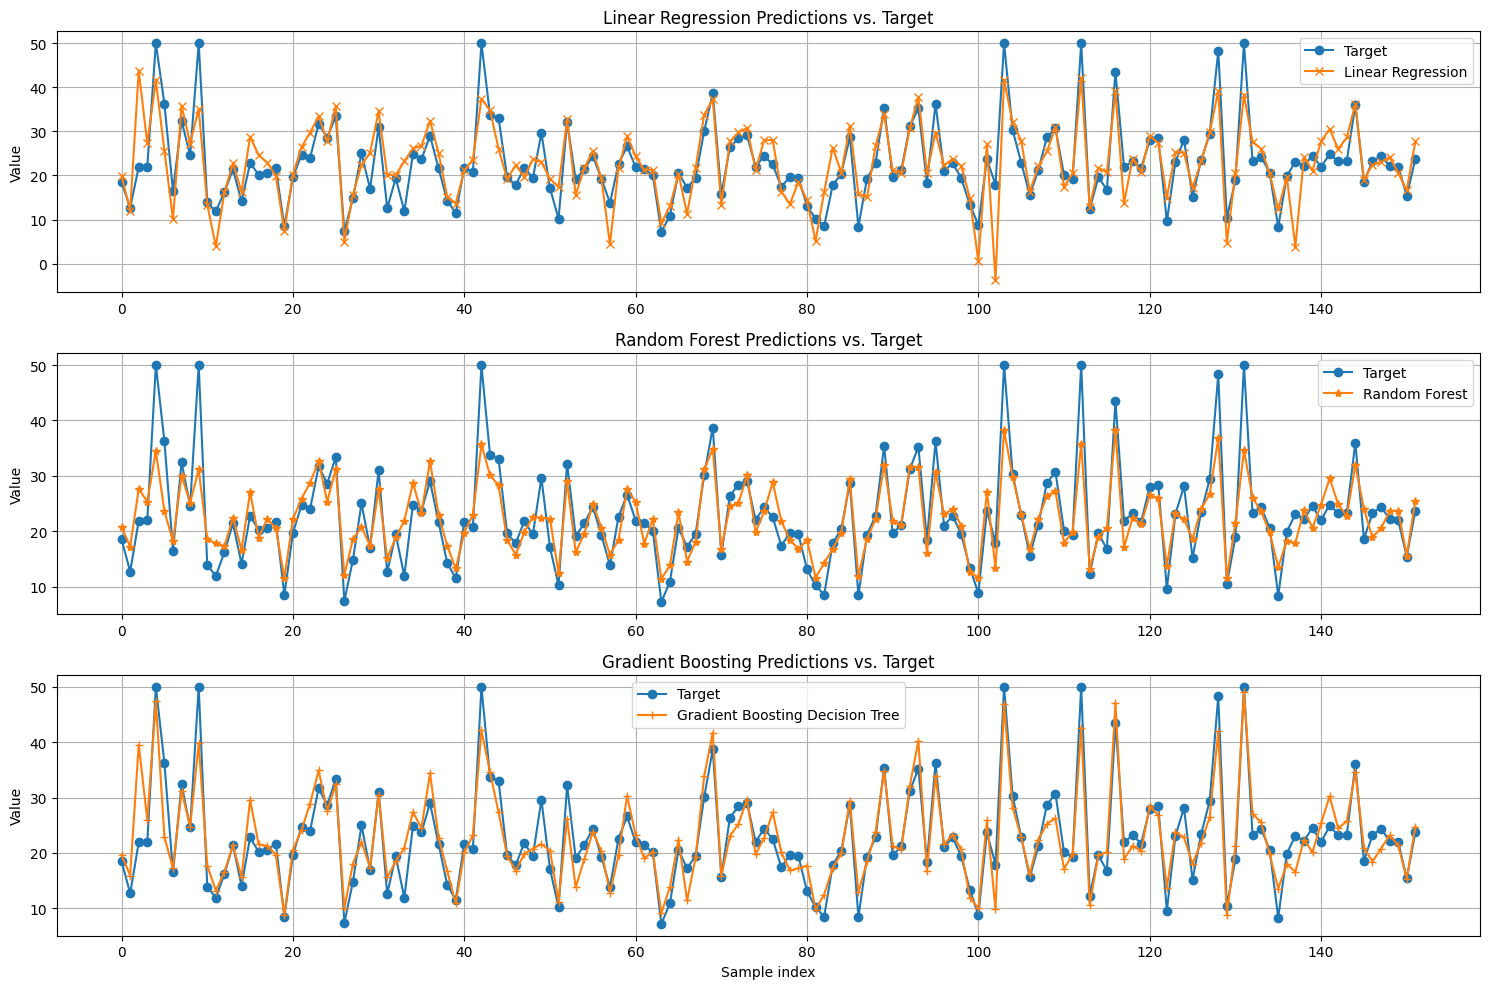

In [18]:
####### Plot for visual analysis #######
x_axis = range(len(y_test))  # Just a simple range for the x-axis

plt.figure(figsize=[15, 10])

# First subplot for Linear Regression
plt.subplot(3, 1, 1)
plt.plot(x_axis, y_test, label='Target', marker='o')
plt.plot(x_axis, pred, label='Linear Regression', marker='x')
plt.title('Linear Regression Predictions vs. Target')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

# Second subplot for RF
plt.subplot(3, 1, 2)  # (rows, columns, panel number)
plt.plot(x_axis, y_test, label='Target', marker='o')
plt.plot(x_axis, y_pred_RF, label='Random Forest', marker='*')
plt.title('Random Forest Predictions vs. Target')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

# Third subplot for GBDT
plt.subplot(3, 1, 3)  # (rows, columns, panel number)
plt.plot(x_axis, y_test, label='Target', marker='o')
plt.plot(x_axis, y_pred, label='Gradient Boosting Decision Tree', marker='+')
plt.title('Gradient Boosting Predictions vs. Target')
plt.xlabel('Sample index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

# Adjust layout to not overlap
plt.tight_layout()

# Show plot
plt.show()

In [ ]:
# TODO: GBDT classification on credit-g dataset

# load data
from sklearn.datasets import fetch_openml
X, y = fetch_openml('credit-g', version=1, return_X_y=True, data_home='credit/', as_frame=False)
y = np.array(list(map(lambda x: 1 if x == 'good' else 0, y)))

# train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8)

gbdt_classifier = GBDT(n_threads = 3,loss='cll', max_depth=4, min_sample_split=4, lamda=3, gamma=0.1, learning_rate=0.1, num_trees=50)

# Fit the model to the training data
gbdt_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred_train = gbdt_classifier.predict(X_train)
y_pred = gbdt_classifier.predict(X_test)
# Evaluate the model using Accuracy
Accuracy_train = accuracy(y_pred_train, y_train)
print(f'Accuracy on train set: {Accuracy_train}')
Accuracy = accuracy(y_pred, y_test)
print(f'Accuracy on test set: {Accuracy}')

Accuracy on train set: 0.7528571428571429
Accuracy on test set: 0.7366666666666667


In [ ]:
# TODO: RF classification on credit-g dataset

# load data
from sklearn.datasets import fetch_openml
X, y = fetch_openml('credit-g', version=1, return_X_y=True, data_home='credit/', as_frame=False)
y = np.array(list(map(lambda x: 1 if x == 'good' else 0, y)))

# train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8)
RF_classifier = RF(n_threads = 2,loss='cll', max_depth=5, min_sample_split=5, lamda=1, gamma=0.1, rf = 0.4, num_trees=50)

# Fit the model to the training data
RF_classifier.fit(X_train, y_train)

# Predict on the train set
y_pred_train = RF_classifier.predict(X_train)
# Evaluate the model using Accuracy
Accuracy_RF_train = accuracy(y_pred_train, y_train)
print(f'Accuracy on train set: {Accuracy_RF_train}')

# Predict on the test set
y_pred = RF_classifier.predict(X_test)
# Evaluate the model using Accuracy
Accuracy_RF = accuracy(y_pred, y_test)
print(f'Accuracy on test set: {Accuracy_RF}')

Accuracy on train set: 0.72
Accuracy on test set: 0.7166666666666667


In [ ]:
# TODO: GBDT classification on breast cancer dataset

# load data
from sklearn import datasets
breast_cancer = datasets.load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target

# train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8)
gbdt_classifier = GBDT(n_threads = 3, loss='cll', max_depth=3, min_sample_split=2, lamda=3, gamma=0.2, learning_rate=0.1, num_trees=50)

# Fit the model to the training data
gbdt_classifier.fit(X_train, y_train)

# Predict on the train set
y_pred_train = gbdt_classifier.predict(X_train)
# Evaluate the model using Accuracy
Accuracy_train = accuracy(y_pred_train, y_train)
print(f'Accuracy on train set: {Accuracy_train}')

# Predict on the test set
y_pred = gbdt_classifier.predict(X_test)
# Evaluate the model using Accuracy
Accuracy = accuracy(y_pred, y_test)
print(f'Accuracy on test set: {Accuracy}')

Accuracy on train set: 0.9974874371859297
Accuracy on test set: 0.9649122807017544


In [ ]:
# TODO: RF classification on breast cancer dataset

# load data
from sklearn import datasets
breast_cancer = datasets.load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target

# train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8)
RF_classifier = RF(n_threads = 2, loss='cll', max_depth=4, min_sample_split=3, lamda=1, gamma=0.1, rf=0.3, num_trees=100)

# Fit the model to the training data
RF_classifier.fit(X_train, y_train)

# Predict on the train set
y_pred_train = RF_classifier.predict(X_train)
# Evaluate the model using Accuracy
Accuracy_RF_train = accuracy(y_pred_train, y_train)
print(f'Accuracy on train set: {Accuracy_RF_train}')

# Predict on the test set
y_pred = RF_classifier.predict(X_test)
# Evaluate the model using Accuracy
Accuracy_RF = accuracy(y_pred, y_test)
print(f'Accuracy on test set: {Accuracy_RF}')

Accuracy on train set: 0.9824120603015075
Accuracy on test set: 0.9532163742690059


# Hyper-parameter Tuning

In [35]:
###### GBDT Regression ######

from sklearn.datasets import load_boston
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import make_scorer, mean_squared_error
import numpy as np

# Load a sample dataset for demonstration (e.g., Boston housing dataset)
X, y = load_boston(return_X_y=True)
# train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8)
# the parameter grid to search
param_grid = {
    'n_estimators': [10, 20, 35, 50],
    'learning_rate': [0.1, 0.5, 1],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 4, 5],
}

# Initialize the GBDT model
gbdt = GradientBoostingRegressor()

scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=gbdt, param_grid=param_grid, scoring=scorer, cv=5, n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Best parameter set found
print("Best parameters:", grid_search.best_params_)

Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 50}


In [38]:
###### RF Regression ######

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_error
import numpy as np

# Load a sample dataset for demonstration (e.g., Boston housing dataset)
X, y = load_boston(return_X_y=True)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8)
# Define the parameter grid to search
param_grid = {
    'n_estimators': [10, 20, 30, 50],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 3, 4, 5],
    'max_features': [0.2, 0.3, 0.4, 0.5]
}

# Initialize the GBDT model
RF_ = RandomForestRegressor()

scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=RF_, param_grid=param_grid, scoring=scorer, cv=5, n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Best parameter set found
print("Best parameters:", grid_search.best_params_)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np

        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

Best parameters: {'max_depth': 5, 'max_features': 0.5, 'min_samples_split': 4, 'n_estimators': 50}


In [42]:
######## GBDT Classification Credit Dataset ########

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import fetch_openml
X, y = fetch_openml('credit-g', version=1, return_X_y=True, data_home='credit/', as_frame=False)
y = np.array(list(map(lambda x: 1 if x == 'good' else 0, y)))

# train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8)

#  parameter grid
param_grid = {
    'n_estimators': [10, 20, 30, 50],
    'learning_rate': [0.1, 0.5, 1],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 4, 5],
}
gbdt = GradientBoostingClassifier()
# 'neg_log_loss' for the scoring parameter
grid_search = GridSearchCV(estimator=gbdt, param_grid=param_grid,
                           scoring='neg_log_loss', cv=5, n_jobs=-1)

# Fit GridSearchCV to your data
grid_search.fit(X_train, y_train)  # Make sure X_train, y_train are defined

# Check the results
print("Best parameters:", grid_search.best_params_)

Best parameters: {'learning_rate': 0.1, 'max_depth': 4, 'min_samples_split': 4, 'n_estimators': 50}


In [41]:
######## RF Classification Credit Dataset ########

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import fetch_openml
X, y = fetch_openml('credit-g', version=1, return_X_y=True, data_home='credit/', as_frame=False)
y = np.array(list(map(lambda x: 1 if x == 'good' else 0, y)))

# train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8)

#  parameter grid
param_grid = {
    'n_estimators': [10, 20, 30, 50],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 3, 4, 5],
    'max_features': [0.2, 0.3, 0.4, 0.5]
}
RF_ = RandomForestClassifier()
# 'neg_log_loss' for the scoring parameter
grid_search = GridSearchCV(estimator=RF_, param_grid=param_grid,
                           scoring='neg_log_loss', cv=5, n_jobs=-1)

# Fit GridSearchCV to your data
grid_search.fit(X_train, y_train)  # Make sure X_train, y_train are defined

# Check the results
print("Best parameters:", grid_search.best_params_)

Best parameters: {'max_depth': 5, 'max_features': 0.4, 'min_samples_split': 5, 'n_estimators': 50}


In [43]:
######## GBDT Classification Breast Cancer Dataset ########

from sklearn import datasets
breast_cancer = datasets.load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target

# train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8)

#  parameter grid
param_grid = {
    'n_estimators': [ 10, 20, 30, 50],
    'learning_rate': [0.1, 0.5, 1],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 4, 5],
}
gbdt = GradientBoostingClassifier()
# 'neg_log_loss' for the scoring parameter
grid_search = GridSearchCV(estimator=gbdt, param_grid=param_grid,
                           scoring='neg_log_loss', cv=5, n_jobs=-1)

# Fit GridSearchCV to your data
grid_search.fit(X_train, y_train)  # Make sure X_train, y_train are defined

# Check the results
print("Best parameters:", grid_search.best_params_)

Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 50}


In [44]:
######## RF Classification Breast Cancer Dataset ########

from sklearn import datasets
breast_cancer = datasets.load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target

# train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8)

#  parameter grid
param_grid = {
    'n_estimators': [ 10, 20, 30, 50],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 3, 4, 5],
    'max_features': [0.2, 0.3, 0.4, 0.5]
}
RF_ = RandomForestClassifier()
# 'neg_log_loss' for the scoring parameter
grid_search = GridSearchCV(estimator=RF_, param_grid=param_grid,
                           scoring='neg_log_loss', cv=5, n_jobs=-1)

# Fit GridSearchCV to your data
grid_search.fit(X_train, y_train)  # Make sure X_train, y_train are defined

# Check the results
print("Best parameters:", grid_search.best_params_)

Best parameters: {'max_depth': 4, 'max_features': 0.3, 'min_samples_split': 3, 'n_estimators': 50}
